In [ ]:
pip install scikit-learn

In [ ]:
pip install seaborn

Train/Val/Test sizes: 800/200/200
Using GPU: NVIDIA GeForce RTX 4070 SUPER
[Epoch 1] train_loss=0.6900 val_loss=0.6599 val_acc=0.5600
*** New best model saved at epoch 1 with val_loss=0.6599 ***
[Epoch 2] train_loss=0.6335 val_loss=0.6524 val_acc=0.6250
*** New best model saved at epoch 2 with val_loss=0.6524 ***
[Epoch 3] train_loss=0.6074 val_loss=0.6153 val_acc=0.6250
*** New best model saved at epoch 3 with val_loss=0.6153 ***
[Epoch 4] train_loss=0.6079 val_loss=0.6069 val_acc=0.6200
*** New best model saved at epoch 4 with val_loss=0.6069 ***
[Epoch 5] train_loss=0.5692 val_loss=0.5906 val_acc=0.6200
*** New best model saved at epoch 5 with val_loss=0.5906 ***
[Epoch 6] train_loss=0.5657 val_loss=0.5886 val_acc=0.6550
*** New best model saved at epoch 6 with val_loss=0.5886 ***
[Epoch 7] train_loss=0.5485 val_loss=0.5932 val_acc=0.6300
[Epoch 8] train_loss=0.5437 val_loss=0.6106 val_acc=0.6500
[Epoch 9] train_loss=0.5559 val_loss=0.5904 val_acc=0.6550
[Epoch 10] train_loss=0.5252

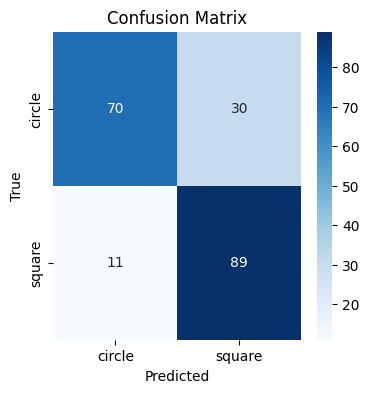

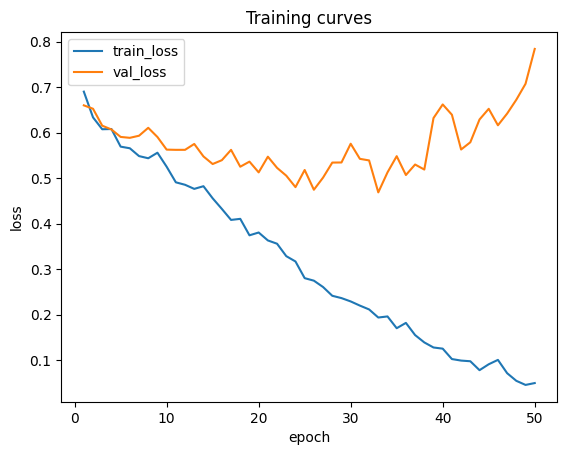

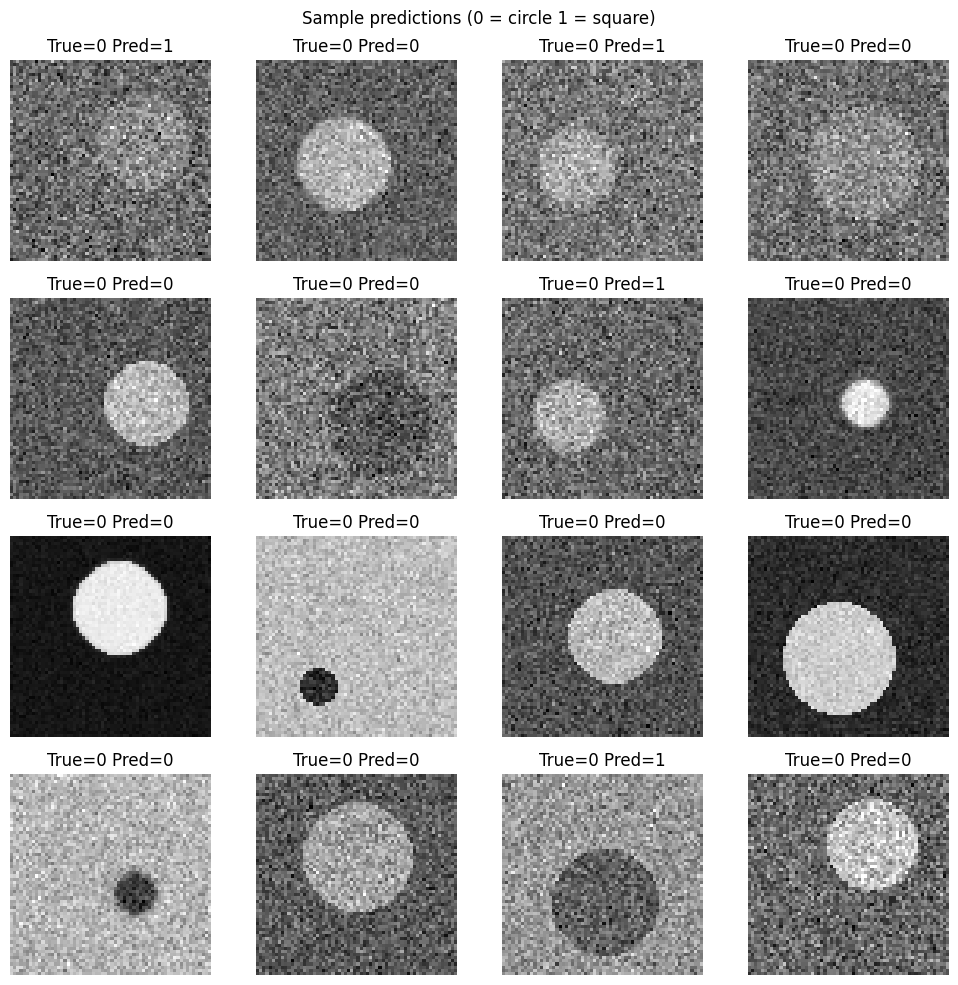

In [11]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn
import sklearn.metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from pathlib import Path
from PIL import Image, ImageDraw, ImageFilter
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns


#--------------- Config -----------------------
BASE_DIR = "./cv_tinkering"
IMG_SIZE = 64
TRAIN_SAMPLES = 800
VAL_SAMPLES = 200
TEST_SAMPLES = 200
BATCH_SIZE = 64
EPOCHS = 50
LR = 1e-3
SEED = 42

os.makedirs(BASE_DIR,exist_ok=True)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

#----------------- Synthetic dataset generation -----------------------
def make_shape_image(shape='CIRCLE', size=IMG_SIZE):
    """ create a grayscale image with a circle or a rotated square with noise and blur. """
    bg_color = int(random.uniform(30,200))
    img = Image.new("L", (size,size), color=bg_color)
    draw = ImageDraw.Draw(img)

    margin = int(size * 0.12)
    min_side = int(size * 0.18)
    max_side = int(size * 0.6)
    w = random.randint(min_side, max_side)
    x0 = random.randint(margin, size - margin - w)
    y0 = random.randint(margin, size - margin - w)
    bbox = [x0, y0, x0+w, y0+w]
    shape_color = int(random.uniform(10,240))

    if shape == 'circle':
        draw.ellipse(bbox, fill=shape_color)
    else:
        square = Image.new("L", (size,size), color=0)
        sq_draw = ImageDraw.Draw(square)
        sq_draw.rectangle(bbox, fill=shape_color)
        angle = random.uniform(-20,20)
        square = square.rotate(angle, resample=IMAGE.BILINEAR)
        img = Image.composite(square, img, square)

    # optional blur and noise
    if random.random() < 0.45:
        img = img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0,1.5)))
    arr = np.array(img).astype(np.float32)
    noise = np.random.normal(scale=random.uniform(2,18),size=arr.shape)
    arr = np.clip(arr + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(arr)

def generate_dataset_per_folder(out_dir, n_per_class):
    out_dir = Path(out_dir)
    for cls in ['circle','square']:
        d = out_dir / cls
        d.mkdir(parents=True,exist_ok=True)
        for i in range(n_per_class):
            img = make_shape_image(shape=cls, size = IMG_SIZE)
            img.save(d/ f"{cls}_{i:04d}.png")

train_dir = Path(BASE_DIR) / "train"
val_dir = Path(BASE_DIR) / "val"
test_dir = Path(BASE_DIR) / "test"

if not any(train_dir.rglob("*.png")):
    generate_dataset_per_folder(train_dir,TRAIN_SAMPLES//2)
if not any(val_dir.rglob("*.png")):
    generate_dataset_per_folder(val_dir,VAL_SAMPLES//2)
if not any(test_dir.rglob("*.png")):
    generate_dataset_per_folder(test_dir,TEST_SAMPLES//2)

# --------------------------- PyTorch dataset ---------------------------
class ShapesDataset(Dataset):
    def __init__(self, root_dir, img_size = IMG_SIZE):
        self.files = sorted(list(Path(root_dir).rglob("*png")))
        self.img_size = img_size
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        p = self.files[idx]
        img = Image.open(p).convert("L")
        if img.size != (self.img_size, self.img_size):
            img = img.resize((self.img_size, self.img_size), resample=Image.BILINEAR)
        arr = np.array(img).astype(np.float32)/ 255.0
        arr = (arr - 0.5) / 0.5
        tensor = torch.from_numpy(arr).unsqueeze(0).float()
        label = 0 if "circle" in p.name else 1
        return tensor, label
            
train_ds = ShapesDataset(train_dir)
val_ds = ShapesDataset(val_dir)
test_ds = ShapesDataset(test_dir)

train_loader = DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True, num_workers=0)  
val_loader = DataLoader(val_ds,batch_size=BATCH_SIZE,shuffle=False, num_workers=0)   
test_loader = DataLoader(test_ds,batch_size=BATCH_SIZE,shuffle=False, num_workers=0)   

print(f"Train/Val/Test sizes: {len(train_ds)}/{len(val_ds)}/{len(test_ds)}")

#--------------------------- Small CNN model --------------------------------
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,16,3,padding=1),nn.ReLU(),nn.MaxPool2d(2),
            nn.Conv2d(16,32,3,padding=1),nn.ReLU(),nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1),nn.ReLU(),nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*(IMG_SIZE//8)*(IMG_SIZE//8),128), nn.ReLU(),
            nn.Linear(128,2)
        )
    def forward(self,x):
        return self.net(x)
            
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")             
if device.type == "cuda":
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")           
model = SmallCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=LR)
criterion = nn.CrossEntropyLoss()

#----------------------- Train/Evaluate -------------------------
def evaluate_metrics(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            total_loss += loss.item() * xb.size(0)

            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    
    # Compute metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='binary')
    rec = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')

    # Optional: show confusion matrix & report
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=['circle','square'])

    print(f"\nLoss={avg_loss:.4f} Acc={acc:.4f} Prec={prec:.4f} Rec={rec:.4f} F1={f1:.4f}")
    print("Confusion Matrix:\n", cm)
    print("\nClassification Report:\n", report)

    return {
        "loss": avg_loss,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "confusion_matrix": cm,
        "report": report
    }

            
train_losses, val_losses, val_accs = [], [], []

# Paths for checkpoints
last_ckpt_path = os.path.join(BASE_DIR, "smallcnn_last.pth")
best_ckpt_path = os.path.join(BASE_DIR, "smallcnn_best.pth")

# Initialize tracking variables
best_val_loss = float('inf')
start_epoch = 1  

# Resume from last checkpoint if it exists
# Can also choose to start from beginning
start_from_scratch = "True"

if start_from_scratch == "True":
    start_epoch = 1
    train_losses, val_losses, val_accs = [], [], []
    
else: 
    if os.path.exists(last_ckpt_path):
        checkpoint = torch.load(last_ckpt_path, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        train_losses = checkpoint.get('train_losses', [])
        val_losses = checkpoint.get('val_losses', [])
        val_accs = checkpoint.get('val_accs', [])
    
    else:
        print("Error restarting from checkpoint")
    

# Training loop
for epoch in range(start_epoch, EPOCHS + 1):
    model.train()
    running = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running += loss.item() * xb.size(0)

    train_loss = running / len(train_loader.dataset)
    val_loss, val_acc = evaluate(model, val_loader)

    # Record metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"[Epoch {epoch}] train_loss={train_loss:.4f} val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

    # --- Save last epoch checkpoint ---
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accs': val_accs,
    }, "checkpoint.pth")


    # --- Save best model checkpoint if validation improves ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
            'best_val_loss': best_val_loss
        }, best_ckpt_path)
        print(f"*** New best model saved at epoch {epoch} with val_loss={val_loss:.4f} ***")

    
#----------------------- Model checkpoints and TorchScript -------------------------
weights_path = os.path.join(BASE_DIR, "smallcnn_weights.pth")
torch.save(model.state_dict(),weights_path)

example_input = torch.randn(1,1,IMG_SIZE,IMG_SIZE).to(device)
traced = torch.jit.trace(model, example_input)
traced_path = os.path.join(BASE_DIR, "smallcnn_trace.pth")
traced.save(traced_path)
print("SAVED:", weights_path, traced_path)

# For loading
# model = SmallCNN()
# model.load_state_dict(torch.load(weights_path))
# model.to(device)
# traced_model = torch.jit.load(traced_path)
# traced_model(example_input)  

# checkpoint = torch.load(checkpoint_path)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

#--------------------------- Test evaluation and sample plots --------------------------------
metrics = evaluate_metrics(model, test_loader)
print("Test loss:", test_loss, "Test acc:", test_acc)


cm = metrics["confusion_matrix"]
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['circle','square'], yticklabels=['circle','square'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# Plots for train/val losses. only if len(train_losses) >= 5
if len(train_losses) >= 5:
    plt.figure()
    plt.plot(range(1,len(train_losses)+1), train_losses, label="train_loss")
    plt.plot(range(1,len(val_losses)+1), val_losses, label="val_loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.title("Training curves")
    plt.show()

# Plots for sample prodictions
n_samples = 16
model.eval()
samples, labels, preds = [], [], []
with torch.no_grad():
    for xb, yb in test_loader:
        out = model(xb.to(device))
        p = out.argmax(dim=1).cpu().numpy()
        samples.extend(xb.numpy())
        labels.extend(yb.numpy())
        preds.extend(p)

        if len(samples) >= n_samples:
            break

n_rows = int(n_samples / 4)
fig, axes = plt.subplots(n_rows, 4, figsize=(10,10))
axes = axes.flatten()

for i in range(n_samples):
    img = (samples[i].squeeze(0) * 0.5 + 0.5)  # denormalize to [0,1]
    axes[i].imshow(img, cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"True={labels[i]} Pred={int(preds[i])}")
    
plt.suptitle("Sample predictions (0 = circle 1 = square)") 
plt.tight_layout()
plt.show()
    



